In [1]:
import networkx as nx


class RandomGraph(object):
    def __init__(self, node_num, p, seed, k=4, m=5, graph_mode="ER"):
        self.node_num = node_num
        self.p = p
        self.k = k
        self.m = m
        self.seed = seed
        self.graph_mode = graph_mode

        self.graph = self.make_graph()

    def make_graph(self):
        # reference
        # https://networkx.github.io/documentation/networkx-1.9/reference/generators.html

        if self.graph_mode is "ER":
            graph = nx.random_graphs.erdos_renyi_graph(self.node_num, self.p, self.seed)
        elif self.graph_mode is "WS":
            graph = nx.random_graphs.watts_strogatz_graph(self.node_num, self.k, self.p, self.seed)
        elif self.graph_mode is "BA":
            graph = nx.random_graphs.barabasi_albert_graph(self.node_num, self.m, self.seed)

        return graph

    def get_graph_info(self):
        in_edges = {}
        in_edges[0] = []
        nodes = [0]
        end = []
        for node in self.graph.nodes():
            neighbors = list(self.graph.neighbors(node))
            # print(node, neighbors)

            edges = []
            check = []
            for neighbor in neighbors:
                if node > neighbor:
                    edges.append(neighbor + 1)
                    check.append(neighbor)
            if not edges:
                edges.append(0)
            in_edges[node + 1] = edges
            if check == neighbors:
                end.append(node + 1)
            nodes.append(node + 1)
        in_edges[self.node_num + 1] = end
        nodes.append(self.node_num + 1)

        # print(nodes, in_edges)
        return nodes, in_edges

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from graph import RandomGraph


# reference, Thank you.
# https://github.com/tstandley/Xception-PyTorch/blob/master/xception.py
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.conv(x)
        x = self.pointwise(x)
        return x


# ReLU-convolution-BN triplet
class Unit(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Unit, self).__init__()

        self.unit = nn.Sequential(
            nn.ReLU(),
            SeparableConv2d(in_channels, out_channels, stride=stride),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.unit(x)


class Node(nn.Module):
    def __init__(self, in_degree, in_channels, out_channels, stride=1):
        super(Node, self).__init__()
        self.in_degree = in_degree
        if len(self.in_degree) > 1:
            self.weights = nn.Parameter(torch.ones(len(self.in_degree)), requires_grad=True)
        self.unit = Unit(in_channels, out_channels, stride=stride)

    def forward(self, *input):
        if len(self.in_degree) > 1:
            x = (input[0] * self.weights[0])
            for index in range(1, len(input)):
                x += (input[index][0] * self.weights[index])
            x = torch.sigmoid(x)
            out = self.unit(x)
        else:
            out = self.unit(input[0])
        return out


class RandWire(nn.Module):
    def __init__(self, node_num, p, seed, in_channels, out_channels):
        super(RandWire, self).__init__()
        self.node_num = node_num
        self.p = p
        self.seed = seed
        self.in_channels = in_channels
        self.out_channels = out_channels

        # get graph nodes and in edges
        graph = RandomGraph(self.node_num, self.p, self.seed)
        self.nodes, self.in_edges = graph.get_graph_info()

        # define input Node
        self.module_list = nn.ModuleList([Node(self.in_edges[0], self.in_channels, self.out_channels, stride=2)])
        # define the rest Node
        self.module_list.extend([Node(self.in_edges[node], self.out_channels, self.out_channels) for node in self.nodes if node > 0])
        self.memory = {}


    def forward(self, x):

        # start vertex
        out = self.module_list[0].forward(x)
        self.memory[0] = out

        # the rest vertex
        for node in range(1, len(self.nodes) - 1):
            if len(self.in_edges[node]) > 1:
                out = self.module_list[node].forward(*[self.memory[in_vertex] for in_vertex in self.in_edges[node]])
            else:
                out = self.module_list[node].forward(self.memory[self.in_edges[node][0]])
            self.memory[node] = out

        out = self.module_list[self.node_num + 1].forward(*[self.memory[in_vertex] for in_vertex in self.in_edges[self.node_num + 1]])
        return out

In [3]:
class Model(nn.Module):
    def __init__(self, node_num, p, seed, in_channels, out_channels):
        super(Model, self).__init__()
        self.node_num = node_num
        self.p = p
        self.seed = seed
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.out_channels // 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(self.out_channels // 2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels // 2, out_channels=self.out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU()
        )
        self.rand_wire1 = nn.Sequential(
            RandWire(self.node_num, self.p, self.seed, self.in_channels, self.out_channels * 2)
        )
        self.rand_wire2 = nn.Sequential(
            RandWire(self.node_num, self.p, self.seed, self.in_channels * 2, self.out_channels * 2)
        )
        self.conv_output = nn.Sequential(
            nn.Conv2d(self.in_channels * 2, 1280, kernel_size=1, stride=2),
            nn.BatchNorm2d(1280)
        )

        self.output = nn.Linear(1280, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.rand_wire1(x)
        x = self.rand_wire2(x)
        x = self.conv_output(x)

        # global average pooling
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        x = torch.squeeze(x)
        x = F.softmax(self.output(x), dim=-1)

        return x

In [4]:
import argparse
from torchviz import make_dot
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Model(7, 0.4, 12, 2, 2)

x = torch.randn(2, 3, 32, 32)
y = model(x)
g = make_dot(y.mean(), params=dict(model.named_parameters()))
g.format='svg'
g.filename = 'image'
g.render(view=False)

0 [4, 5, 6]
1 [2]
2 [1, 4, 6]
3 [5]
4 [0, 2, 5]
5 [0, 3, 4, 6]
6 [0, 2, 5]
0 [4, 5, 6]
1 [2]
2 [1, 4, 6]
3 [5]
4 [0, 2, 5]
5 [0, 3, 4, 6]
6 [0, 2, 5]


'image.svg'

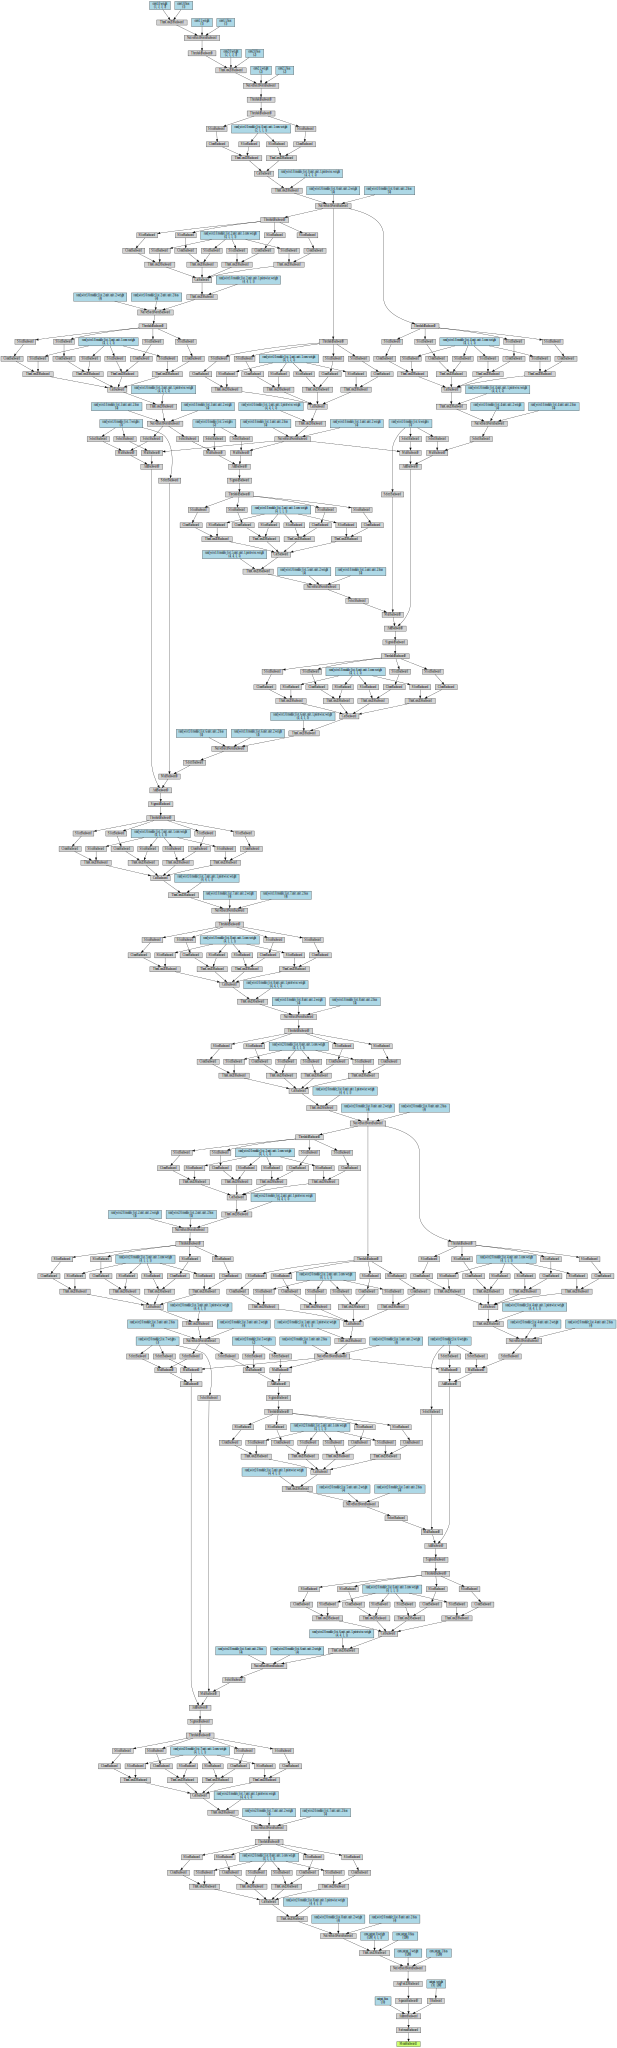

In [5]:
g

In [8]:
!cairosvg image.svg -o image.png